# Transformer

**For fair comparison and benchmarking no pretrained models will be used**

In [1]:
import os
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

In [2]:
from fastai.text import *
from fastai.data_block import *
from fastai.text.models.transformer import init_transformer

In [3]:
data_path = Path("../../data/quora/")

In [4]:
train_df = pd.read_csv(data_path/'train.csv')
test_df = pd.read_csv(data_path/'test.csv')

In [5]:
train_df.shape, test_df.shape

((1306122, 3), (56370, 2))

In [6]:
train_df.head(1)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0


### LM Training

Now fastai supports a generic language model learner with `AWD-LSTM`, `QRNN`, `Transformer` and `Transformer XL`

In [11]:
data_lm = TextLMDataBunch.load(".")

In [12]:
tfmer_lm_config = dict(ctx_len=512, n_layers=6, n_heads=8, d_model=512, d_head=64,
                       d_inner=2048, resid_p=0.1, attn_p=0.1, ff_p=0.1, embed_p=0.1,
                       output_p=0., bias=True, scale=True, act=Activation.GeLU, double_drop=False,
                        tie_weights=True, out_bias=False, init=init_transformer, mask=True)

In [13]:
learn = language_model_learner(data=data_lm, arch=Transformer, config=tfmer_lm_config,
                               drop_mult=1.0, pretrained=False)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03


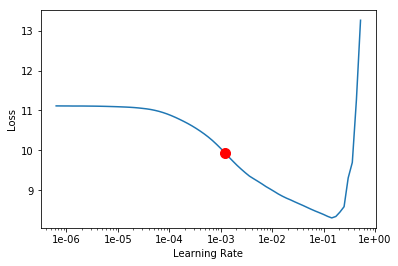

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(5, 1.2e-3)

epoch,train_loss,valid_loss,accuracy
1,4.261740,4.210060,0.331522
2,3.895312,3.835322,0.360712
3,3.715817,3.663746,0.374517
4,3.588986,3.552589,0.386148
5,3.509318,3.517272,0.389458


In [17]:
learn.save_encoder("transformer-enc")

### Clas Training 

Constant prediction problem

https://www.quora.com/Why-does-my-convolutional-neural-network-always-produce-the-same-outputs

There are number of reasons:

- Dead ReLU(s) in the network
- Vanishing gradient issues
- In correct weights initialization
- Weights are either getting saturated or deminished
- Data is not properly pre-processes like normalized, scaled, zero-centered
- The depth and/or width is inadequate for the input data
- There is a logic bug in the code

In [7]:
1/0

ZeroDivisionError: division by zero

In [12]:
# metric
from utils import fbeta_binary

In [13]:
data_clas = TextClasDataBunch.load(".", bs=16)

In [14]:
tfmer_clas_config = dict(ctx_len=100, n_layers=12, n_heads=12, d_model=512, d_head=64,
                         d_inner=2048, resid_p=0.1, attn_p=0.1, ff_p=0.1, embed_p=0.1,
                         output_p=0., bias=False, scale=True, act=Activation.GeLU,
                         double_drop=False, init=init_transformer, mask=False)

In [15]:
learn = text_classifier_learner(data=data_clas, arch=Transformer,
                                config=tfmer_clas_config, pretrained=False)

In [16]:
# metrics
learn.metrics = [accuracy] + [fbeta_binary(thresh=t) for t in np.arange(0.1, 1., 0.2)]

In [17]:
# learn.save_encoder("transformer-enc")

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02


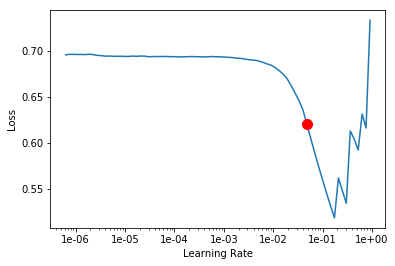

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary
1,0.258852,36.148445,0.938275,0.000000,0.000000,0.000000,0.000000,0.000000


KeyboardInterrupt: 

In [21]:
xb, yb = learn.data.one_batch()

In [22]:
xb.shape

torch.Size([16, 306])

In [23]:
ob = learn.model.eval()(xb.cuda())

In [24]:
ob

(tensor([[ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324],
         [ 802.3708, -802.3324]], device='cuda:0', grad_fn=<AddmmBackward>),
 [tensor([[[-0.0128, -0.0040, -0.0006,  ...,  0.0476,  0.0009,  0.0002],
           [-0.0128, -0.0040, -0.0006,  ...,  0.0476,  0.0009,  0.0002],
           [-0.0128, -0.0040, -0.0006,  ...,  0.0476,  0.0009,  0.0002],
           ...,
           [-0.0128, -0.0040, -0.0006,  ...,  0.0476,  0.0009,  0.0002],
           [-0.0128, -0.0040, -0.0006,  ...,  0.0476,  0.0009,  0.0002],
           [-0.0128, -0.0040, -0.0006,  ...,  0

In [38]:
p = learn.model[1].parameters()

In [46]:
next(p)

Parameter containing:
tensor([ 1.0781, -1.0781], device='cuda:0', requires_grad=True)

### AutoLR

In [ ]:
 def plot(self, skip_start=10, skip_end=5):
    "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
    lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
    losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
    _, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    mg = (np.gradient(np.array([x.item() for x in losses]))).argmin()
    print(f"Min numerical gradient: {lrs[mg]:.2E}")
    ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
    self.min_grad_lr = lrs[mg]

In [136]:
def smooth(alpha, x0, x1): return alpha*x0 + (1-alpha)*x1

def smooth_losses(losses, alpha=0.5):
    smoothed_losses = []
    x0 = losses[0]
    for i in np.arange(len(losses)-1):
        x0 = smooth(0.3, losses[i+1], x0)
        smoothed_losses.append(x0)
    return smoothed_losses
    
def plot_v2(self, skip_start=10, skip_end=5, alpha=0.5):
    "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
    lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
    losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
    # smoothing
    if alpha: losses, lrs = smooth_losses(losses, alpha), lrs[1:]
    _, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    mg = (np.gradient(np.array([x.item() for x in losses]))).argmin()
    print(f"Min numerical gradient: {lrs[mg]:.2E}")
    ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
    self.min_grad_lr = lrs[mg]

In [144]:
from scipy.interpolate import UnivariateSpline
def smooth_by_spline(xs, ys, **kwargs):
    xs = np.arange(len(ys))
    spl = UnivariateSpline(xs, ys, **kwargs)
    ys = spl(xs)
    return ys

def plot_v3(self, skip_start=10, skip_end=5, **kwargs):
    "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
    lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
    losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
    losses = [x.item() for x in losses]
    losses = smooth_by_spline(lrs, losses, **kwargs)
    # smoothing
    _, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    mg = (np.gradient(np.array(losses))).argmin()
    print(f"Min numerical gradient: {lrs[mg]:.2E}")
    ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
    self.min_grad_lr = lrs[mg]

In [145]:
Recorder.plot_v3 = plot_v3

Min numerical gradient: 6.31E-07


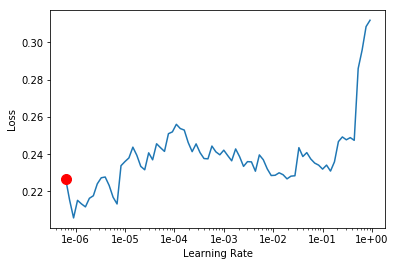

In [146]:
# original
learn.recorder.plot()

Min numerical gradient: 7.59E-07


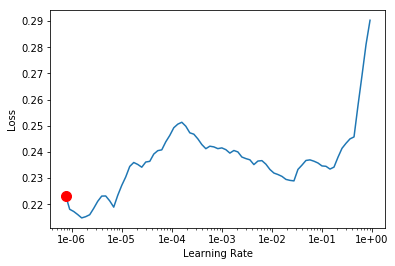

In [147]:
# exponential smoothing, alpha = smoothing coeff
learn.recorder.plot_v2(skip_end=5, alpha=0.9)

Min numerical gradient: 4.37E-03


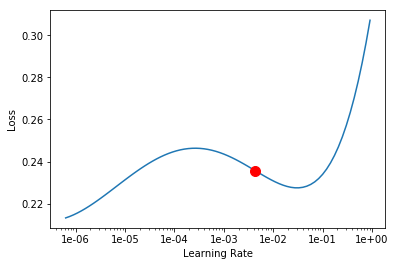

In [150]:
# spline, k = order of the spline
learn.recorder.plot_v3(k=5)